In [1]:
# Installing required packages
!pip install pyspark
!pip install findspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5fa5a0dee6c225c349c221b65b005fbab3f6b63bebfcf61ed30ea794ccdb3f60
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

##  Load the data


In [6]:
spark = SparkSession \
    .builder \
    .appName("clustering") \
    .getOrCreate()


In [7]:
sqlContext = SQLContext(spark)

## Select input data

In [8]:
from google.colab import files


uploaded = files.upload()

Saving customers.csv to customers.csv


In [9]:
file='customers.csv'

df = sqlContext.read.load(file,
                          format='com.databricks.spark.csv',
                          header='true',inferSchema='true')

In [10]:
df.count()

440

In [11]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Fresh_Food,440,12000.297727272728,12647.328865076885,3,112151
Milk,440,5796.265909090909,7380.3771745708445,55,73498
Grocery,440,7951.277272727273,9503.162828994346,3,92780
Frozen_Food,440,3071.931818181818,4854.673332592367,25,60869


# Prepare the features

In [23]:
from pyspark.ml.feature import VectorAssembler
featuresUsed = df.columns

assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features")
assembled = assembler.transform(df)

# Choose number of cluster of Kmean

In [24]:
number_of_clusters = 3

In [25]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k = number_of_clusters)

In [26]:
model = kmeans.fit(assembled)

# Make prediction and show evaluation

In [27]:
predictions = model.transform(assembled)

In [28]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  336|
|         2|   60|
|         0|   44|
+----------+-----+



In [29]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
cost = evaluator.evaluate(predictions)

In [30]:
print(cost)

0.6667195645736799


In [45]:
centers = model.clusterCenters()

In [46]:
print(centers)

[array([ 4961.33333333, 22778.44444444, 33150.88888889,  2352.66666667]), array([9683.08196721, 2432.93442623, 3333.83606557, 1461.08196721]), array([32717., 16784., 13626., 60869.]), array([2846.84375 , 1941.203125, 2112.1875  , 1461.0625  ]), array([41240.46153846,  2741.07692308,  3486.07692308,  3176.92307692]), array([72594. ,  3942. ,  9855.5, 12615. ]), array([112151.,  29627.,  18148.,  16745.]), array([11353.94117647,  8950.47058824, 12995.52941176,  1698.94117647]), array([54118.4,  3509.2,  4704. ,  8686.8]), array([ 8565.,  4980., 67298.,   131.]), array([16117., 46197., 92780.,  1026.]), array([26206.625,  4398.375,  4271.625, 11375.375]), array([34444.33333333, 55375.33333333, 49094.33333333,  4007.66666667]), array([  718.81818182,  6932.54545455, 21902.63636364,   953.63636364]), array([ 7522.83333333,  2837.5       ,  4025.33333333, 19038.16666667]), array([16462.86666667,  3495.        ,  3378.86666667,  8447.46666667]), array([18149.23529412,  5112.76470588, 10800.29

In [32]:
elbowset = assembled.select("features")
elbowset.persist()

DataFrame[features: vector]

# Data validation to find the best K

In [33]:
import numpy as np
# Evaluate clustering by computing Silhouette score

cost = np.zeros(30)
for k in range(2,31):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1)

    model = kmeans.fit(elbowset)
    prediction=model.transform(elbowset)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(prediction)
    cost[k-1] = silhouette

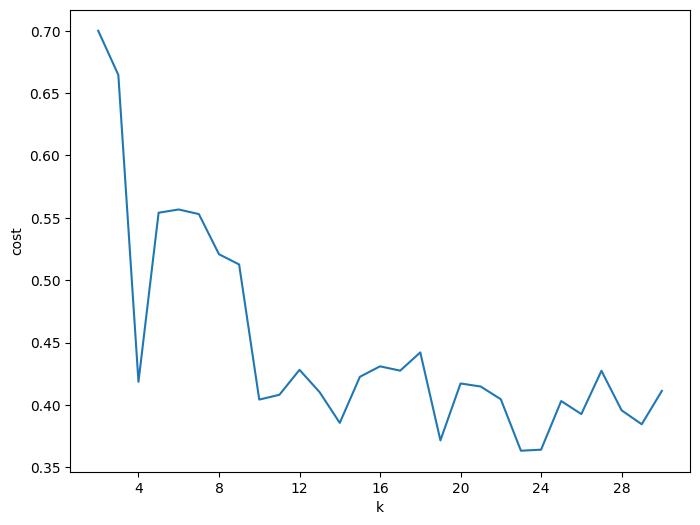

In [34]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,31),cost[1:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Scale the input data with 0 mean unit(1) variance

In [35]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="features_std", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [47]:
kmean = KMeans(k = number_of_clusters,featuresCol="features_std")

In [48]:
model_std = kmean.fit(scaledData)

In [53]:
prediction_std = model_std.transform(scaledData)


In [55]:
prediction_std.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   52|
|         2|   11|
|         0|  377|
+----------+-----+



In [57]:
evaluator = ClusteringEvaluator()
cost = evaluator.evaluate(prediction_std)
print(cost)

0.6669900302186956


## Perform elbow plot in the range of 2 - 31

In [61]:
elbowset = scaledData.select("features_std")
elbowset.persist()

DataFrame[features_std: vector]

In [66]:
# Evaluate clustering by computing Silhouette score
cost = np.zeros(30)
for k in range(2,31):
    kmeans = KMeans(featuresCol="features_std")\
            .setK(k)\
            .setSeed(1)

    model = kmeans.fit(elbowset)
    prediction=model.transform(elbowset)
    evaluator = ClusteringEvaluator(featuresCol="features_std")
    silhouette = evaluator.evaluate(prediction)
    cost[k-1] = silhouette

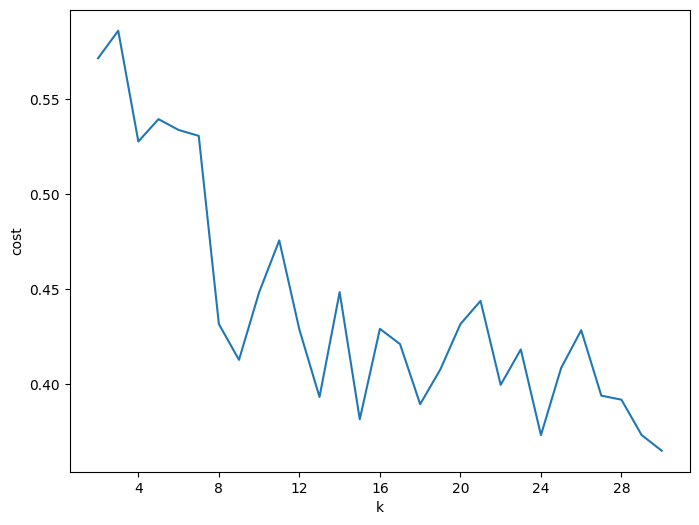

In [67]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,31),cost[1:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Use K-mean with selected K

In [68]:
kmeans = KMeans(featuresCol="features_std",k=16, seed=1)
model = kmeans.fit(scaledData)
transformed = model.transform(scaledData)

In [69]:
centers = model.clusterCenters()
centers

[array([ 1.56604069, -0.14846619, -0.2278264 , -0.17978845]),
 array([-0.41075136, -0.50943891, -0.55272578,  0.44045462]),
 array([1.59517496, 5.48464301, 6.45732975, 0.19542712]),
 array([-0.50890337,  0.59531056,  1.38627089, -0.30834256]),
 array([-0.44144086, -0.494777  , -0.39120158,  2.22807333]),
 array([ 1.60173761,  0.24744455, -0.27651607,  3.83868633]),
 array([-0.59043618, -0.46748407, -0.52459639, -0.41002384]),
 array([-0.57688344,  0.29546484,  0.23944511, -0.37003362]),
 array([ 3.4095326 , -0.23621788, -0.21986242,  0.95925012]),
 array([-0.27162239, -0.11059948,  6.24494432, -0.60579397]),
 array([7.91872366, 3.22893174, 1.07298201, 2.81647543]),
 array([ 0.64118264, -0.22331853, -0.39777714,  1.29352866]),
 array([ 0.86379522,  9.17320788,  2.54259799, -0.42946902]),
 array([ 0.36378138, -0.42855306, -0.38703354, -0.24939562]),
 array([1.80130544, 3.32919762, 0.94144685, 9.39910166]),
 array([-0.40530455,  2.31339587,  1.96440452, -0.0845551 ])]

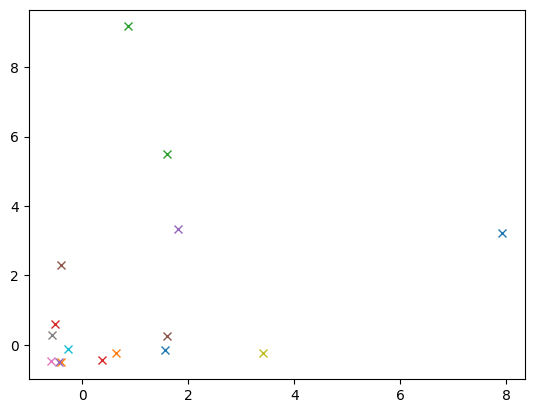

In [75]:
for k in range(0,16):
    plt.plot(centers[k][0],centers[k][1],'x')


In [1]:
spark.stop()

NameError: name 'spark' is not defined